# 导入必要的库

In [ ]:
import numpy as np

# 用于图片预处理
from keras.preprocessing.image import load_img, img_to_array, array_to_img

# 导入后端，允许我们进行一些更加细节的操作
from keras import backend as K

# keras自带的VGG16网络
from keras.applications.vgg16 import preprocess_input, VGG16

# 用于显示训练结果
from IPython.display import display

# 优化器，用于最小化损失
from keras.optimizers import SGD, Adam

# 设置内容图片和风格图片的路径
content_image_path = './data/pixelGradientOptim/content.jpg'
style_image_path = './data/pixelGradientOptim/style.jpg'

# 设置固定的图片大小
w, h = load_img(content_image_path).size
# 把长度设置为256像素，宽度成比例放大
height = 256
width = int(w * height / h)


# 图片读取和处理

In [2]:
def preprocess_image(image_path):
    # 读入图片

    image = load_img(path = image_path, target_size = (height, width))
    
    # 将一张PIL格式的图像转化为numpy数组
    
    image = img_to_array(image)
    
    # 扩张维度
    # 原来是一张图片 [长, 宽, 通道]，加了一维之后变成 [批次, 长 ,宽 ,通道]， 
    # 这是为了符合VGG16输入的格式
    # 我们的输入都是单张图片，所以批次大小为1
    
    image = np.array([image])
    
    # https://github.com/keras-team/keras-applications/blob/master/keras_applications/imagenet_utils.py
    # 将图片转化为VGG16读取的格式
    # 将RGB转化为BGR， 各个通道减去平均值
    image = preprocess_input(image)
    return image

# preprocess_image(content_image_path)
# 读取图片
content_image = preprocess_image(content_image_path)
style_image = preprocess_image(style_image_path)

# 将张量转化为图片

In [3]:
# 将张量转化为图片
# 是preprocess的逆过程
def postprocess_array(x):
    t = x.copy()
    t = t.reshape((height, width, 3))
    # BGR三个通道各自加上像素平均值
    vgg_mean = [103.939, 116.779, 123.68]
    for i in range(3):
        t[:, :, i] += vgg_mean[i]
    # 将BGR转化为RGB
    t = t[:,:,::-1]
    # 保证图片中像素颜色值是0～255中的整数
    t = np.clip(t, 0, 255).astype('uint8')
    return t

# 导入VGG16网络

In [ ]:
# 为内容图片和风格图片创建常量对象
content_input = K.constant(content_image)
style_input = K.constant(style_image)

# output_image用于存放生成的图片
# 用内容图片初始化
output_image = K.variable(content_image)

# 将三个张量拼接为单个张量
# 有关后端的函数可以在https://keras.io/zh/backend/查询到
input_tensor = K.concatenate([content_input, style_input, output_image], axis=0)

# 使用预训练的ImageNet的权重构建VGG16网络
# https://keras.io/zh/applications/
# include_top: 是否包含顶层的全连接层，此处不需要
model = VGG16(input_tensor=input_tensor, include_top=False)
print('Model has been loaded.')

# 将模型每一层的名字和输出放到一个字典里，方便寻找
output_dict = dict([(layer.name, layer.output) for layer in model.layers])

#查看模型结构
model.summary()

# 计算内容损失

In [5]:
# 定义权重
content_weight = 1
style_weight = 1e4


# 计算内容损失
def get_content_loss(content_features, output_features):
    # square 平方
    # sum 求和
    return 0.5 * K.sum(K.square(output_features - content_features))

# 取出选定的卷积层
layer_feat = output_dict['block5_conv3']

# 取出内容图片的特征
content_feat = layer_feat[0, :, :, :]

# 取出输出图片的特征
output_feat = layer_feat[2, :, :, :]

# 把内容损失加入总的损失函数中
loss = content_weight * get_content_loss(content_feat, output_feat)

# 计算风格损失

In [6]:
# 计算图像张量的格拉姆矩阵，用于捕捉图像的风格
def get_gram_matrix(x):
    # permute_dimensions 重新排列张量的轴
    # 原来是[长，宽，通道]
    # 转化之后是[通道，长，宽]
    
    # batch_flatten 将批次中的每一个样本展平
    # dot 求点积
    
    # print(x)
    # print(K.permute_dimensions(x, (2, 0, 1)))
    
    feature_matrix = K.batch_flatten(K.permute_dimensions(x, (2, 0, 1)))
    gram_matrix = K.dot(feature_matrix, K.transpose(feature_matrix))
    return gram_matrix

# 计算单个卷积核的风格损失
def get_style_loss(style_features, output_features):
    G = get_gram_matrix(style_features)
    A = get_gram_matrix(output_features)
    
    channel_number = int(style_features.shape[2])
    size = int(style_features.shape[0]) * int(style_features.shape[1])
    return K.sum(K.square(G - A)) / (4.0 * (channel_number ** 2) * (size ** 2))

layer_names = ['block1_conv1', 'block2_conv1',
               'block3_conv1', 'block4_conv1',
               'block5_conv1']

for layer_name in layer_names:
    # 取出某个卷积层的输出
    layer_feat = output_dict[layer_name]
    # 每个批次的第二章图片是风格图片，取出它的特征图
    style_feat = layer_feat[1, :, :, :]
    # 取出输出图片的特征图
    output_feat = layer_feat[2, :, :, :]
    # 计算风格损失
    single_style_loss = get_style_loss(style_feat, output_feat)
    # 计算各层风格损失的平均，加到损失函数中
    loss += (style_weight / len(layer_names)) * single_style_loss

# 计算损失和梯度

In [7]:
# updater = SGD(lr = 1e-5).get_updates([output_image], [], loss)
updater = Adam(lr = 10).get_updates(loss, [output_image])

# 产生一个函数，没有输入，输出是loss和输出图片，并更新updater
fit = K.function([], [loss, output_image], updater)

# 训练

iteration 0
current loss value: 6533234000000.0


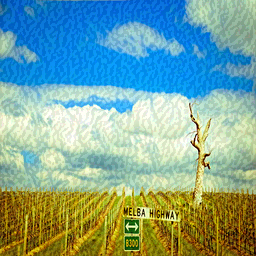

iteration 0 finished
iteration 1
current loss value: 3314950000000.0


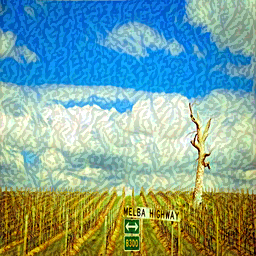

iteration 1 finished
iteration 2
current loss value: 2812812000000.0


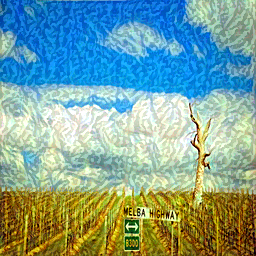

iteration 2 finished
iteration 3
current loss value: 2119593200000.0


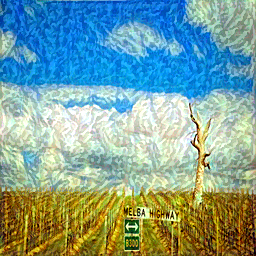

iteration 3 finished
iteration 4
current loss value: 1617759300000.0


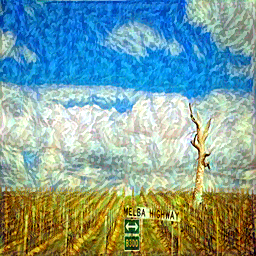

iteration 4 finished
iteration 5
current loss value: 1246540100000.0


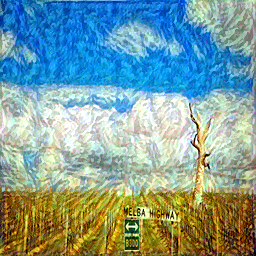

iteration 5 finished
iteration 6
current loss value: 992140200000.0


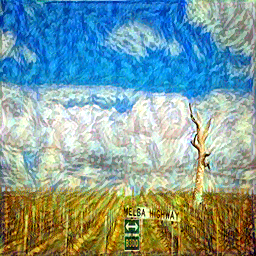

iteration 6 finished
iteration 7
current loss value: 823548100000.0


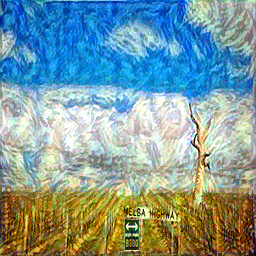

iteration 7 finished
iteration 8
current loss value: 703848250000.0


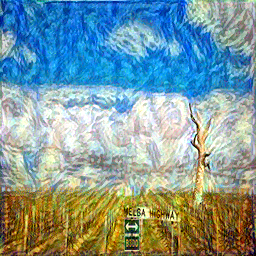

iteration 8 finished
iteration 9
current loss value: 610572240000.0


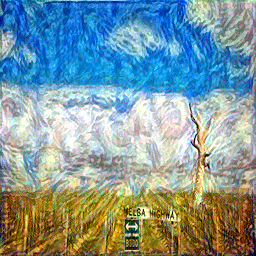

iteration 9 finished


In [8]:
iterations = 10
out = None
for i in range(iterations):
    
    print("iteration", i)
    
    # 计算损失和输出图像
    f_val, out = fit([])
    print('current loss value:', f_val)
    # 保存每十轮迭代后生成的图像
    img = postprocess_array(out)
    # 显示图像
    display(array_to_img(img))
    print('iteration %d finished' % (i))

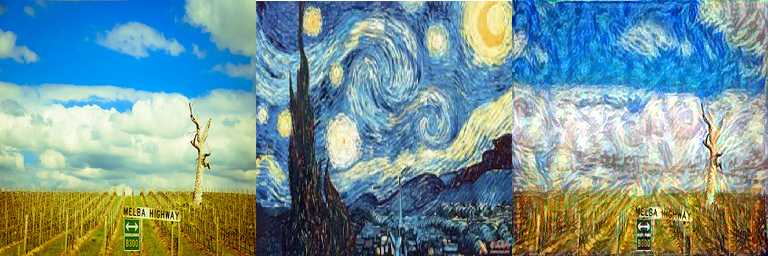

In [9]:
content_out = postprocess_array(content_image)
style_out = postprocess_array(style_image)

out_new = postprocess_array(out)
img_out = np.concatenate([content_out, style_out, out_new], axis = 1)
display(array_to_img(img_out))